In [1]:
import sys 
import os

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Move up one directory from the notebook location
notebook_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add that directory to sys.path if not already present
if notebook_root not in sys.path:
    sys.path.insert(0, notebook_root)
    
from Matrix_methods.Simulate import simulate_parallel
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor

bias of sample_pulse before 60 ps: -0.04720603984513083
Time domain sampling: 995


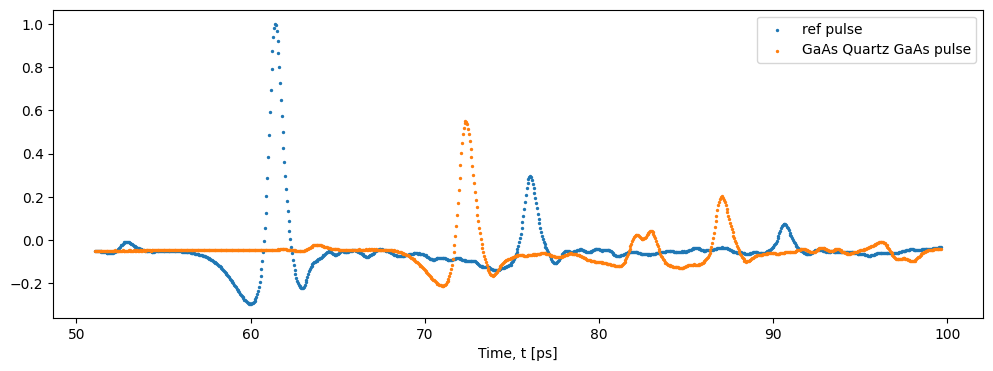

In [2]:
ref_path = 'GaAs_Quartz_data/ref_pulse.csv'
ref_df = pd.read_csv(ref_path)
ref_df = ref_df.dropna() # Drop nan values from matlab files
time_axis_ref = ref_df['Time_ps'].to_numpy()
ref_pulse = ref_df['Pulse'].to_numpy()
scaler = max(ref_pulse)
ref_pulse /= scaler

sample_pulse_path = 'GaAs_Quartz_data/Quartz_Ga_pulse.csv'
sample_pulse_df = pd.read_csv(sample_pulse_path)
sample_pulse_df = sample_pulse_df.dropna()# Drop nan values from matlab files
time_axis_sample = sample_pulse_df['Time_ps'].to_numpy()
sample_pulse = sample_pulse_df['Pulse'].to_numpy()
sample_pulse /= scaler

# Remove bias from samples
mask = time_axis_sample < 60
bias = np.mean(sample_pulse[mask])

print("bias of sample_pulse before 60 ps:", bias)
#ref_pulse -= bias
#sample_pulse -= bias

## Known parameters
d_quartz = 1e-3
d_gaas = 0.4*1e-3
L = len(ref_pulse)
print(f'Time domain sampling: {L}')

# Structure: [GaAs-Quartz-GaAs]

plt.figure(figsize=(12,4))
plt.scatter(time_axis_ref, ref_pulse, label='ref pulse', s=2)
plt.scatter(time_axis_sample, sample_pulse, label='GaAs Quartz GaAs pulse', s=2)
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [3]:
## Check time steps are consistent in t_axis
# Compute time differences between consecutive samples
dt = np.diff(time_axis_ref)

# Check for uniform time step (within a small tolerance)
tolerance = 0.5e-12  # adjust as needed based on your signal's precision
is_uniform = np.all(np.abs(dt - dt[0]) < tolerance)

print("Time steps are uniform:", is_uniform)
if is_uniform:
    deltat = dt[0]
    print(f'delta_t: {deltat} ps')
if not is_uniform:
    print("Min dt:", np.min(dt))
    print("Max dt:", np.max(dt))
    print("Mean dt:", np.mean(dt))

deltat = deltat * 1e-12 # Convert to seconds for calcs

Time steps are uniform: True
delta_t: 0.048828125 ps


Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (3.1999999999999997, 3.4)
Layer 1 - k ∈ (-0.02, 0.0)
Layer 1 - D ∈ (0.00025, 0.00055)
Layer 2 - n ∈ (1.8499999999999999, 2.05)
Layer 2 - k ∈ (-0.011, 0.009000000000000001)
Layer 2 - D ∈ (0.0008500000000000001, 0.00115)
Layer 3 - n ∈ (3.1999999999999997, 3.4)
Layer 3 - k ∈ (-0.02, 0.0)
Layer 3 - D ∈ (0.00025, 0.00055)
Bayes params: [((3.3501843223745595-0.0011886389692515875j), 0.0004353579116978788), ((2.05+0.003570776245811069j), 0.001068754649937136), ((3.2306632589083337-0.017186999658469874j), 0.0005173625203724988)]


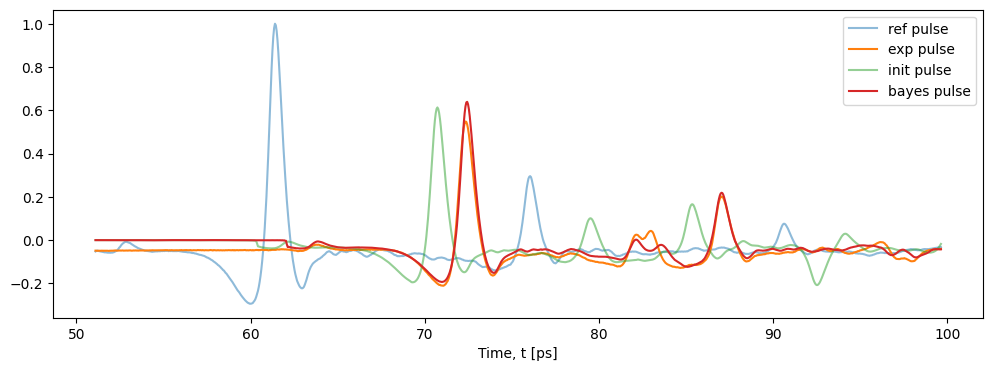

In [4]:
# Convert ref to torch tensor 
ref_pulse_t = torch.tensor(ref_pulse, dtype=torch.float32) 
sample_pulse_t = torch.tensor(sample_pulse, dtype=torch.float32) 
# Initial guesses
n_quartz = 1.95
k_quartz = -0.001
n_gaas = 3.3
k_gaas = -0.01


optimize_mask = [
    (True, True, True),  # GaAs 
    (True, True, True),  # Quartz 
    (True, True, True)   # GaAs 
]

init_guess = [
    ((n_gaas + 1j*k_gaas), d_gaas),        # GaAs 
    ((n_quartz + 1j*k_quartz), d_quartz),  # Quartz 
    ((n_gaas + 1j*k_gaas), d_gaas)         # GaAs 
]

init_pulse = simulate_parallel(ref_pulse_t, init_guess, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

Bayes_model = BayesianLayeredExtractor(ref_pulse_t, sample_pulse_t, deltat=deltat, layers_init=init_guess, optimize_mask=optimize_mask)
bayes_params = Bayes_model.bayesian_optimization(n_calls=50)

Bayesian_pulse = simulate_parallel(ref_pulse_t, bayes_params, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

print(f'Bayes params: {bayes_params}')
plt.figure(figsize=(12,4))
plt.plot(time_axis_ref, ref_pulse_t, label='ref pulse', alpha=0.5)
plt.plot(time_axis_sample, sample_pulse_t, label='exp pulse')
plt.plot(time_axis_sample, init_pulse, label='init pulse', alpha = 0.5)
plt.plot(time_axis_sample, Bayesian_pulse, label='bayes pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

Fine-tuning 9 parameters for 300 iterations.
Iteration 29, Loss: 2.686034e-02, Layer 0: n=3.3664, k=0.00752, D=441.41 µm | Layer 1: n=2.0561, k=-0.00651, D=1091.53 µm | Layer 2: n=3.2012, k=-0.02108, D=495.64 µm
Iteration 59, Loss: 2.644273e-02, Layer 0: n=3.3741, k=0.00799, D=438.10 µm | Layer 1: n=2.0524, k=-0.01288, D=1088.45 µm | Layer 2: n=3.2152, k=-0.00584, D=495.96 µm
Iteration 89, Loss: 2.634513e-02, Layer 0: n=3.3859, k=0.01130, D=435.17 µm | Layer 1: n=2.0491, k=-0.01758, D=1090.16 µm | Layer 2: n=3.2296, k=0.00419, D=493.83 µm
Iteration 119, Loss: 2.652062e-02, Layer 0: n=3.3873, k=-0.01355, D=436.03 µm | Layer 1: n=2.0385, k=0.00642, D=1097.30 µm | Layer 2: n=3.2302, k=-0.02813, D=494.82 µm
Iteration 149, Loss: 2.630238e-02, Layer 0: n=3.4000, k=0.00761, D=434.87 µm | Layer 1: n=2.0364, k=-0.00922, D=1095.11 µm | Layer 2: n=3.2460, k=-0.00999, D=491.96 µm
Iteration 179, Loss: 2.620105e-02, Layer 0: n=3.4094, k=0.01164, D=431.74 µm | Layer 1: n=2.0339, k=-0.01708, D=1098.15

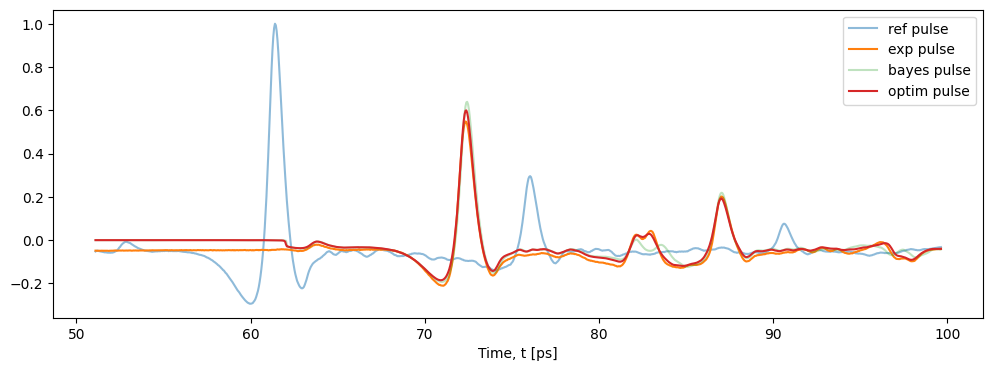

In [6]:
grad_optimizer = LayeredExtractor(ref_pulse_t, sample_pulse_t, deltat, bayes_params, optimize_mask, lr=0.01)
optim_params = grad_optimizer.optimize(num_iterations=300, updates=30, alpha=1)



optim_pulse = simulate_parallel(ref_pulse_t, optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]

print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(time_axis_ref, ref_pulse_t, label='ref pulse', alpha=0.5)
plt.plot(time_axis_sample, sample_pulse_t, label='exp pulse')
plt.plot(time_axis_sample, Bayesian_pulse, label='bayes pulse', alpha = 0.3)
plt.plot(time_axis_sample, optim_pulse, label='optim pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.show()

In [7]:
optim_params

[((3.452364683151245+0.009832367300987244j), 0.00042527218465693295),
 ((2.0111868381500244-0.013805488124489784j), 0.0011108281323686242),
 ((3.3351266384124756+0.0035974408965557814j), 0.00047832357813604176)]

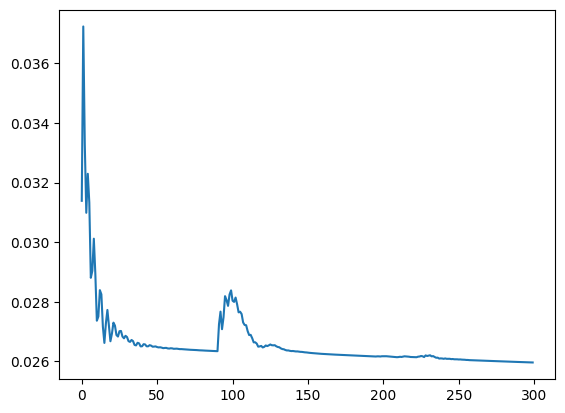

In [8]:
plt.plot(grad_optimizer.loss_history)